In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import functools
import random
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import svm

In [3]:
#Run single challenge on given XOR_PUF
def XOR_PUF(challenge_vector, stage_delays, n_PUF, n_stages):
    feature_vectors = []
    results = []
    for k in range(n_PUF): 
        feature_vector = [] 
        for i in range(n_stages): 
            feature = 1 
            for j in range(i, n_stages): 
                feature = feature * pow(-1, challenge_vector[j])
            feature_vector.append(feature) 
        feature_vector.append(1)
        results.append(np.dot(stage_delays[k], feature_vector) > 0)
        feature_vectors.append(feature_vector)
    
    #Flatten the feature vectors
    flat = []
    for sublist in feature_vectors:
        for element in sublist:
            flat.append(element)
    return flat, functools.reduce(lambda x, y: x ^ y, results)

In [4]:
#Run n crps on a single iPUF
def iPUF(upper_layer, lower_layer, n_stages, pos, n_crp):
    upper_stage_delays = [np.random.normal(size=n_stages+1) for _ in range(upper_layer)]
    lower_stage_delays = [np.random.normal(size=n_stages+2) for _ in range(lower_layer)]
    
    x=[]
    y=[]
    for k in range(n_crp):
        upper_challenge = np.random.randint(2, size=n_stages)
        upper_feature, upper_res = XOR_PUF(upper_challenge, upper_stage_delays, upper_layer, n_stages)
        lower_challenge = np.insert(upper_challenge, pos, upper_res)
        lower_feature, lower_res = XOR_PUF(lower_challenge, lower_stage_delays, lower_layer, n_stages+1)
        x.append(lower_feature)
        y.append(lower_res)
    x_array = np.array(x) 
    y_array = np.array(y)    
    return x_array, y_array


In [5]:
#run a single experiment
x_array, y_array = iPUF(2,2,32,16,10000)
X_train, X_test, Y_train, Y_test = train_test_split(x_array, y_array, test_size = 0.2, random_state = 42)
svc = svm.SVC().fit(X_train, Y_train)
print(svc.score(X_test, Y_test))

0.7845


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
[0.7, 0.6983333333333334, 0.705, 0.748, 0.7291666666666666, 0.7664285714285715, 0.789375, 0.7883333333333333, 0.8015, 0.8113636363636364, 0.8125, 0.8153846153846154, 0.8171428571428572, 0.8183333333333334, 0.8178125, 0.826764705882353, 0.8477777777777777, 0.8336842105263158, 0.841, 0.8416666666666667, 0.8422727272727273, 0.8519565217391304, 0.8554166666666667, 0.8544, 0.8478846153846153, 0.8438888888888889, 0.8546428571428571, 0.8612068965517241, 0.8498333333333333, 0.8590322580645161, 0.86140625, 0.865, 0.8672058823529412, 0.8582857142857143, 0.8706944444444444, 0.8705405405405405, 0.8696052631578948, 0.8688461538461538, 0.872625, 0.8791463414634146, 0.8705952380952381, 0.882093023255814, 0.865909090909091, 0.8765555555555555, 0.8822826086956522, 0.8785106382978723, 0.8884375, 0.8766326530612245]


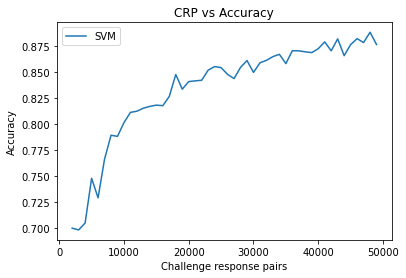

In [6]:
#Plot CRP graph
def Nr_of_crp_iPUF():
    crps = []
    preds_svm = []
    x_array, y_array = iPUF(2,2,32,16,50000)
    for i in range(2, 50):
        crp = i*1000
        print(i)
        c = list(zip(x_array, y_array))
        random.shuffle(c)
        c = c[0:crp]
        x_subset, y_subset = zip(*c)
        X_train, X_test, Y_train, Y_test = train_test_split(x_subset, y_subset, test_size = 0.2, random_state = 42)
        crps.append(crp)
        svc = svm.SVC().fit(X_train, Y_train)
        preds_svm.append(svc.score(X_test, Y_test))

    print(preds_svm)
    plt.plot(crps, preds_svm, label = "SVM")
    plt.xlabel('Challenge response pairs')
    plt.ylabel('Accuracy')
    plt.title('CRP vs Accuracy')
    plt.legend()
    plt.show
    return

Nr_of_crp_iPUF()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
[0.831, 0.8335, 0.83825, 0.848, 0.83625, 0.837, 0.84875, 0.848, 0.8115, 0.82575, 0.83975, 0.84625, 0.85975, 0.8375, 0.846, 0.851]


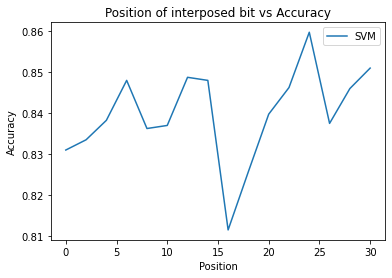

In [7]:


#Plot position graph
def i_pos_iPUF():
    pos = []
    preds_svm = []
    for i in range(0, 16):
        print(i)
        x_subset, y_subset = iPUF(2,2,32,i*2,20000)
        X_train, X_test, Y_train, Y_test = train_test_split(x_subset, y_subset, test_size = 0.2, random_state = 42)
        pos.append(i*2)
        svc = svm.SVC().fit(X_train, Y_train)
        preds_svm.append(svc.score(X_test, Y_test))

    print(preds_svm)
    plt.plot(pos, preds_svm, label = "SVM")
    plt.xlabel('Position')
    plt.ylabel('Accuracy')
    plt.title('Position of interposed bit vs Accuracy')
    plt.legend()
    plt.show
    return

i_pos_iPUF()

1
2
4
8
16
[0.978, 0.8465, 0.54575, 0.49725, 0.4825]


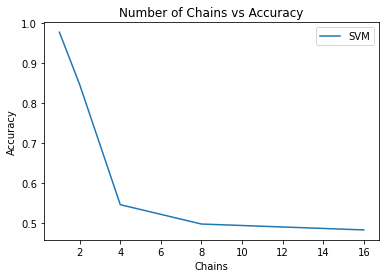

In [8]:
#plot chain
def n_XOR():
    n = []
    preds_svm = []
    for i in [1,2,4,8,16]:
        print(i)
        x_subset, y_subset = iPUF(i,i,32,int(32/(2*i)),20000)
        X_train, X_test, Y_train, Y_test = train_test_split(x_subset, y_subset, test_size = 0.2, random_state = 42)
        n.append(i)
        svc = svm.SVC().fit(X_train, Y_train)
        preds_svm.append(svc.score(X_test, Y_test))

    print(preds_svm)
    plt.plot(n, preds_svm, label = "SVM")
    plt.xlabel('Chains')
    plt.ylabel('Accuracy')
    plt.title('Number of Chains vs Accuracy')
    plt.legend()
    plt.show
    return

n_XOR()

1
2
3
4
5
[0.632, 0.68775, 0.779, 0.922, 0.986]


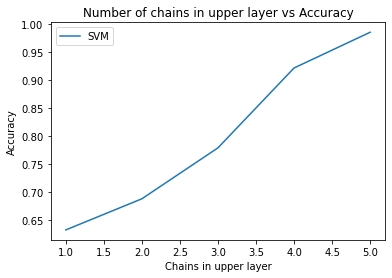

In [9]:
#plot imbalance graph
def chain_imbalance():
    n = []
    preds_svm = []
    for i in range(1,6):
        print(i)
        x_subset, y_subset = iPUF(i,6-i,16,8,20000)
        X_train, X_test, Y_train, Y_test = train_test_split(x_subset, y_subset, test_size = 0.2, random_state = 42)
        n.append(i)
        svc = svm.SVC().fit(X_train, Y_train)
        preds_svm.append(svc.score(X_test, Y_test))

    print(preds_svm)
    plt.plot(n, preds_svm, label = "SVM")
    plt.xlabel('Chains in upper layer')
    plt.ylabel('Accuracy')
    plt.title('Number of chains in upper layer vs Accuracy')
    plt.legend()
    plt.show
    return

chain_imbalance()